In [294]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution

from typing import Callable, Tuple

import torch
from diffusers import DDPMPipeline


In [295]:
# def algorithm2_estimate_singular_values(
#     score_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
#     x0: torch.Tensor,                 # shape (1, C, H, W)
#     t0: torch.Tensor,                 # shape (1,) or scalar tensor (time / timestep)
#     sigma_t0: float | torch.Tensor,   # scalar
# ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
#     """
#     Algorithm 2.

#     Require:
#       score_fn: fonction qui renvoie s_theta(x, t) (même shape que x)
#       x0: échantillon de data-set (1,C,H,W)
#       t0: temps (tensor scalaire ou (1,))
#       sigma_t0: niveau de bruit (scalaire)

#     Returns:
#       s: singular values (d,)
#       v: left singular vectors (d,d)  (torch.linalg.svd convention: U)
#       w: right singular vectors (d,d) (Vh.T)
#       S: matrice (d,d)
#     """

#     # 1) Sample x0 ~ p0(x) : fourni en entrée
#     # 2) d <- dim(x0)
#     d = x0.numel()
#     shape = x0.shape

#     # 3) S <- empty matrix
#     S = torch.empty((d, 0), device=x0.device, dtype=x0.dtype)

#     # 4-8) Sample right/left perturbations
#     Xp = []
#     Xm = []
#     for i in range(d):
#         # 5) x+ ~ N(x0, sigma^2 I)
#         x_plus = x0 + sigma_t0 * torch.randn_like(x0)
#         # 6) x- ~ N(x0, sigma^2 I)
#         x_minus = x0 + sigma_t0 * torch.randn_like(x0)
#         # 7) x- <- 2 x0 - x-
#         x_minus = 2 * x0 - x_minus
#         Xp.append(x_plus)
#         Xm.append(x_minus)

#     Xp = torch.cat(Xp, dim=0)  # (d, C, H, W)
#     Xm = torch.cat(Xm, dim=0)  # (d, C, H, W)
#     print(f"Xp shape: {Xp.shape}, Xm shape: {Xm.shape}")

#     # 9) orthogonalized perturbations
#     # On orthogonalise les deltas autour de x0, puis on reconstruit x~ = x0 + delta~
#     x0_flat = x0.reshape(1, d)
#     dp = (Xp.reshape(d, d) - x0_flat)  # (d,d) lignes = deltas+
#     dm = (Xm.reshape(d, d) - x0_flat)  # (d,d) lignes = deltas-

#     # Orthogonalisation séparée pour + et - (le papier dit (x+, x-) -> orthogonalized)
#     # Ici on applique QR aux transposées pour rendre les LIGNES orthonormales.
#     Qp, _ = torch.linalg.qr(dp.T)  # (d,d)
#     Qm, _ = torch.linalg.qr(dm.T)  # (d,d)

#     dp_ortho = Qp.T
#     dm_ortho = Qm.T

#     Xp_tilde = (x0_flat + dp_ortho).reshape(d, *shape[1:])  # (d,C,H,W)
#     Xm_tilde = (x0_flat + dm_ortho).reshape(d, *shape[1:])  # (d,C,H,W)
#     # Xp_tilde = ((torch.linalg.qr(Xp.reshape(d, d))[0])).reshape(d, *shape[1:])  # (d,C,H,W)
#     # Xm_tilde = ((torch.linalg.qr(Xm.reshape(d, d))[0])).reshape(d, *shape[1:])  # (d,C,H,W)
#     # Xp_tilde = ((torch.linalg.qr(Xp.reshape(d, d))[0])).reshape(d, *shape[1:])  # (d,C,H,W)
#     # Xm_tilde = ((torch.linalg.qr(Xm.reshape(d, d))[0])).reshape(d, *shape[1:])  # (d,C,H,W)

#     # 10-12) remplir S colonne par colonne
#     # (On suit exactement: append (s(x+)-s(x-))/2 as new column)
#     for i in range(d):
#         s_plus = score_fn(Xp_tilde[i:i+1], t0)   # (1,C,H,W)
#         s_minus = score_fn(Xm_tilde[i:i+1], t0)  # (1,C,H,W)
#         col = ((s_plus - s_minus) / 2.0).reshape(d, 1)      # (d,1)
#         S = torch.cat([S, col], dim=1)  # append column

#     # 13) SVD(S)
#     # torch.linalg.svd retourne U, S, Vh avec S non vectorisée? -> S est vecteur des SVs
#     U, sing_vals, Vh = torch.linalg.svd(S, full_matrices=True)

#     # papier: (si), (vi), (wi) <- SVD(S)
#     # on renvoie sing_vals, U, V (où V = Vh^T), et S
#     V = Vh.transpose(-2, -1)

#     return sing_vals, U, V, S

In [314]:
def algorithm2_estimate_singular_values(
    score_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    x0: torch.Tensor,                 # shape (1, C, H, W)
    t0: torch.Tensor,                 # shape (1,) or scalar tensor (time / timestep)
    sigma_t0: float | torch.Tensor,   # scalar
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Algorithm 2.

    Require:
      score_fn: fonction qui renvoie s_theta(x, t) (même shape que x)
      x0: échantillon de data-set (1,C,H,W)
      t0: temps (tensor scalaire ou (1,))
      sigma_t0: niveau de bruit (scalaire)

    Returns:
      s: singular values (d,)
      v: left singular vectors (d,d)  (torch.linalg.svd convention: U)
      w: right singular vectors (d,d) (Vh.T)
      S: matrice (d,d)
    """

    # 1) Sample x0 ~ p0(x) : fourni en entrée
    # 2) d <- dim(x0)
    d = x0.numel()
    shape = x0.shape

    # 3) S <- empty matrix
    S = torch.empty((d, 0), device=x0.device, dtype=x0.dtype)

    # 4-8) Sample right/left perturbations
    Xp = []
    Xm = []
    for i in range(d):
        n = torch.randn_like(x0)
        # 5) x+ ~ N(x0, sigma^2 I)
        x_plus = x0 + sigma_t0 * n
        # 6) x- ~ N(x0, sigma^2 I)
        x_minus = x0 + sigma_t0 * n
        # 7) x- <- 2 x0 - x-
        x_minus = 2 * x0 - x_minus
        Xp.append(x_plus)
        Xm.append(x_minus)

    Xp = torch.cat(Xp, dim=0)  # (d, C, H, W)
    Xm = torch.cat(Xm, dim=0)  # (d, C, H, W)
    print(f"Xp shape: {Xp.shape}, Xm shape: {Xm.shape}")

    # 9) orthogonalized perturbations
    # On orthogonalise les deltas autour de x0, puis on reconstruit x~ = x0 + delta~
    # x0_flat = x0.reshape(1, d)
    # dp = (Xp.reshape(d, d) - x0_flat)  # (d,d) lignes = deltas+
    # dm = (Xm.reshape(d, d) - x0_flat)  # (d,d) lignes = deltas-

    # # Orthogonalisation séparée pour + et - (le papier dit (x+, x-) -> orthogonalized)
    # # Ici on applique QR aux transposées pour rendre les LIGNES orthonormales.
    # Qp, _ = torch.linalg.qr(dp.T)  # (d,d)
    # Qm, _ = torch.linalg.qr(dm.T)  # (d,d)

    # dp_ortho = Qp.T
    # dm_ortho = Qm.T

    # # print(dp_ortho)
    # # dp_ortho = dp_ortho * dp.norm(dim=1, keepdim=True)
    # # print(f"Norms dp: {dp.norm(dim=1, keepdim=True)[0]}")
    # # print(dp_ortho)

    # # dm_ortho = dm_ortho * dm.norm(dim=1, keepdim=True)

    # Xp_tilde = (x0_flat + dp_ortho).reshape(d, *shape[1:])  # (d,C,H,W)
    # Xm_tilde = (x0_flat + dm_ortho).reshape(d, *shape[1:])  # (d,C,H,W)

    ################################################################################

    x0_flat = x0.reshape(-1)              # (d,)
    d = x0_flat.numel()

    # 1) Sample right perturbations: x_plus ~ N(x0, sigma^2 I)
    #    => delta = x_plus - x0 = sigma * z
    Zp = torch.randn(d, d, device=device)  # (d,d)
    Zm = torch.randn(d, d, device=device)  # (d,d)
    # colonne j : une direction brute
    # delta_j = sigma * Z[:,j]

    # 2) Orthonormalize directions (QR): Q colonnes orthonormales
    Qp, _ = torch.linalg.qr(Zp)  # Q: (d,d)
    Qm, _ = torch.linalg.qr(Zm)  # Q: (d,d)

    # 3) Build paired perturbations, couplées et symétriques
    #    Ici chaque déplacement a norme ~1, donc pas = sigma constant
    deltasp = sigma_t0 * Qp  # (d,d), colonne j = sigma*q_j
    deltasm = sigma_t0 * Qm  # (d,d), colonne j = sigma*q_j

    # On renvoie des batchs de taille d
    # Chaque élément est une image/vec perturbé
    x_plus_tilde  = (x0_flat[:, None] + deltasp).T  # (d,d) -> (d,d)
    x_minus_tilde = (x0_flat[:, None] - deltasm).T  # (d,d)

    # Remet en forme originale (d, *x0.shape)
    x_plus_tilde  = x_plus_tilde.reshape(d, *shape[1:])
    x_minus_tilde = x_minus_tilde.reshape(d, *shape[1:])

    Xp_tilde = x_plus_tilde
    Xm_tilde = x_minus_tilde

    # 10-12) remplir S colonne par colonne
    # (On suit exactement: append (s(x+)-s(x-))/2 as new column)
    for i in range(d):
        s_plus = score_fn(Xp_tilde[i:i+1], t0)   # (1,C,H,W)
        s_minus = score_fn(Xm_tilde[i:i+1], t0)  # (1,C,H,W)
        col = ((s_plus - s_minus) / 2.0).reshape(d, 1)      # (d,1)
        S = torch.cat([S, col], dim=1)  # append column

    # 13) SVD(S)
    # torch.linalg.svd retourne U, S, Vh avec S non vectorisée? -> S est vecteur des SVs
    U, sing_vals, Vh = torch.linalg.svd(S, full_matrices=True)

    # papier: (si), (vi), (wi) <- SVD(S)
    # on renvoie sing_vals, U, V (où V = Vh^T), et S
    V = Vh.transpose(-2, -1)

    return sing_vals, U, V, S

# # test the algorithm
# alpha_bar = scheduler.alphas_cumprod[0].to(x0.dtype).view(-1, 1, 1, 1)
# sigma_t = torch.sqrt(1.0 - alpha_bar)

# res = algorithm2_estimate_singular_values(
#     score_fn,
#     x0,
#     torch.tensor([0], device=device),
#     sigma_t0=sigma_t,
# )


In [336]:
def algorithm1_estimate_singular_values(
    score_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    x0: torch.Tensor,                 # shape (1, C, H, W)
    t0: torch.Tensor,                 # shape (1,) or scalar tensor (time / timestep)
    sigma_t0: float | torch.Tensor,   # scalar
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Algorithm 2.

    Require:
      score_fn: fonction qui renvoie s_theta(x, t) (même shape que x)
      x0: échantillon de data-set (1,C,H,W)
      t0: temps (tensor scalaire ou (1,))
      sigma_t0: niveau de bruit (scalaire)

    Returns:
      s: singular values (d,)
      v: left singular vectors (d,d)  (torch.linalg.svd convention: U)
      w: right singular vectors (d,d) (Vh.T)
      S: matrice (d,d)
    """

    # 1) Sample x0 ~ p0(x) : fourni en entrée
    # 2) d <- dim(x0)
    d = x0.numel()
    shape = x0.shape

    # 3) S <- empty matrix
    S = torch.empty((d, 0), device=x0.device, dtype=x0.dtype)

    # 4-8) Sample right/left perturbations
    X = []
    for i in range(d):
        n = torch.randn_like(x0)
        x = x0 + sigma_t0 * n
        X.append(x)

    X = torch.cat(X, dim=0)

    Q, _ = torch.linalg.qr(X.reshape(d, d).T)
    # bring back Q norm
    Q = Q * X.reshape(d, d).norm(dim=0, keepdim=True)
    Q = Q.reshape(d, *shape[1:])
    print(X.reshape(d, d).norm(dim=0, keepdim=True))

    for i in range(d):
        s = score_fn(Q[i:i+1], t0).reshape(d, 1)    
        S = torch.cat([S, s], dim=1)  # append column

    U, sing_vals, Vh = torch.linalg.svd(S, full_matrices=True)

    return sing_vals, U, Vh.T, S

In [337]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
pipe = pipe.to(device)

unet = pipe.unet
scheduler = pipe.scheduler

unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 99.52it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [338]:
def score_fn(x, t0):
    # x: (B,1,28,28), t0: tensor (1,) ou (B,)
    if t0.ndim == 1 and t0.shape[0] == 1:
        t = t0.expand(x.shape[0]).to(device)
    else:
        t = t0.to(device)

    with torch.no_grad():
        eps_pred = unet(x, t).sample  # (B,1,28,28)

    # sigma_t = sqrt(1 - alpha_bar_t)
    alpha_bar = scheduler.alphas_cumprod[t].to(x.dtype).view(-1, 1, 1, 1)
    sigma_t = torch.sqrt(1 - alpha_bar)

    # score ≈ - eps / sigma
    return -eps_pred / sigma_t
    #return -eps_pred / np.sqrt(t + 0.01)

In [339]:
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# MNIST: on met dans [-1, 1] (standard pour diffusion)
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1),
])

mnist = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
x0, y = mnist[101]                      # x0: (1,28,28)
x0 = x0.unsqueeze(0).to(device)       # (1,1,28,28)



# Modèle diffusion MNIST (pré-entraîné HF)
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
unet = pipe.unet.eval()
scheduler = pipe.scheduler

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 83.25it/s]


In [340]:
score_fn(x0, torch.tensor([0], device=device))[0, 0].shape

torch.Size([28, 28])

In [341]:
# test the algorithm
alpha_bar = scheduler.alphas_cumprod[0].to(x0.dtype).view(-1, 1, 1, 1)
sigma_t = torch.sqrt(1.0 - alpha_bar)

res = algorithm1_estimate_singular_values(
    score_fn,
    x0,
    torch.tensor([0], device=device),
    sigma_t0=sigma_t,
)

tensor([[27.9910, 27.9866, 28.0194, 28.0010, 28.0093, 28.0051, 27.9990, 27.9948,
         27.9952, 27.9949, 27.9897, 27.9921, 28.0076, 27.9845, 28.0063, 28.0041,
         28.0001, 27.9909, 28.0242, 28.0085, 28.0099, 28.0074, 27.9915, 28.0009,
         27.9946, 28.0000, 28.0090, 27.9986, 27.9987, 28.0052, 27.9845, 27.9867,
         27.9922, 27.9780, 27.9815, 28.0107, 28.0084, 28.0025, 27.9889, 27.9852,
         27.9956, 28.0105, 27.9894, 28.0175, 27.9803, 28.0166, 28.0026, 28.0067,
         27.9880, 28.0034, 27.9935, 28.0057, 27.9883, 28.0112, 28.0121, 28.0063,
         28.0119, 28.0083, 28.0086, 28.0088, 27.9983, 27.9960, 27.9925, 28.0116,
         28.0031, 27.9898, 28.0102, 28.0070, 27.9880, 27.9940, 27.9908, 28.0260,
         28.0073, 28.0053, 28.0079, 27.9988, 27.9931, 28.0078, 28.0090, 27.9957,
         27.9984, 27.9920, 28.0181, 28.0112, 27.9931, 28.0116, 27.9976, 28.0011,
         27.9963, 27.9944, 27.9983, 27.9840, 28.0031, 27.9992, 28.0041, 28.0063,
         28.0039, 27.9893, 2

In [342]:
sing_val = res[0]
sing_val

tensor([14389.6553,  7154.7148,  7093.0542,  6952.4077,  6915.6802,  6885.7031,
         6852.6895,  6836.5317,  6805.3467,  6789.9946,  6756.7998,  6724.1191,
         6701.0488,  6652.0630,  6649.3677,  6620.7788,  6602.7227,  6589.1670,
         6557.3999,  6541.3486,  6509.2705,  6502.8354,  6489.8120,  6471.4761,
         6447.1035,  6439.8364,  6420.5723,  6410.4448,  6380.8359,  6374.9331,
         6360.7500,  6346.0903,  6342.5347,  6332.9487,  6324.4150,  6307.0435,
         6296.8218,  6291.5200,  6274.8906,  6264.4751,  6254.9795,  6242.2422,
         6227.0479,  6219.4722,  6212.7920,  6194.3359,  6191.7871,  6187.7759,
         6173.4741,  6168.7993,  6147.6626,  6145.3076,  6143.3896,  6132.7036,
         6124.7983,  6115.0244,  6111.8354,  6101.3350,  6090.7148,  6085.7070,
         6076.7642,  6069.1475,  6061.4912,  6054.0449,  6050.1665,  6047.8818,
         6041.3452,  6021.9492,  6010.3721,  6002.1553,  5996.1616,  5993.4155,
         5989.8389,  5977.1655,  5972.93

In [343]:
sing_val = res[0]
sing_val = sing_val.cpu().numpy()
sing_val = sing_val[1:]
sing_val /= sing_val.max()
sing_val

array([1.        , 0.9913818 , 0.9717239 , 0.9665906 , 0.9624008 ,
       0.9577865 , 0.9555282 , 0.9511695 , 0.9490238 , 0.9443842 ,
       0.93981653, 0.93659204, 0.9297454 , 0.9293687 , 0.92537284,
       0.9228492 , 0.9209545 , 0.9165145 , 0.91427106, 0.90978754,
       0.90888816, 0.9070679 , 0.9045051 , 0.9010986 , 0.9000829 ,
       0.89739037, 0.8959749 , 0.8918365 , 0.8910115 , 0.88902915,
       0.8869802 , 0.8864832 , 0.8851434 , 0.88395065, 0.8815227 ,
       0.88009405, 0.879353  , 0.87702876, 0.875573  , 0.8742458 ,
       0.87246555, 0.87034184, 0.869283  , 0.8683494 , 0.8657698 ,
       0.86541355, 0.8648529 , 0.86285394, 0.86220056, 0.8592464 ,
       0.8589172 , 0.85864913, 0.85715556, 0.85605067, 0.8546846 ,
       0.85423887, 0.8527712 , 0.8512869 , 0.85058695, 0.84933704,
       0.84827244, 0.84720236, 0.8461616 , 0.8456195 , 0.8453002 ,
       0.8443866 , 0.84167564, 0.84005755, 0.8389091 , 0.83807135,
       0.83768755, 0.83718765, 0.8354163 , 0.8348256 , 0.83449

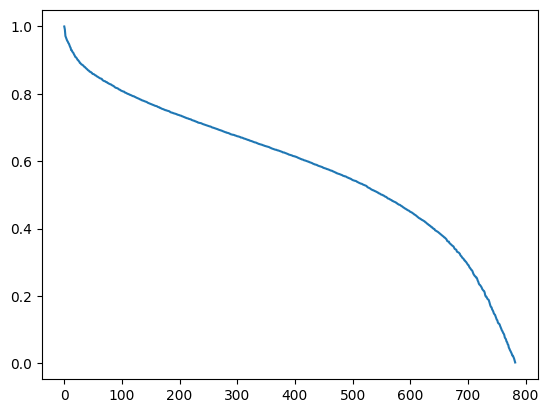

In [344]:
plt.plot(list(range(len(sing_val))), sing_val)